In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from toolz.curried import get, curry

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define environment

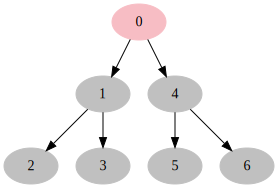

In [33]:
from distributions import Normal
from mouselab import MouselabEnv

def make_env(mu=0, sigma=6, quantization=6, branching=(2,2), **kwargs):
    reward = Normal(mu, sigma).to_discrete(quantization).apply(int)
    return MouselabEnv.new_symmetric(branching, reward, cost=1, **kwargs)

env = make_env(ground_truth=False, term_belief=True)
env.render()

# Optimal policy

Because we can compute the true optimal Q function, we can implement the optimal policy
as a `SoftmaxPolicy` using `Q` as a preference function, and a very low temperature.

In [34]:
from exact import solve
from policies import SoftmaxPolicy
Q, V, *_ = solve(env)
optimal_policy = SoftmaxPolicy(Q)
V(env.init)

3.3012811413394685

## Simulate rollouts

Running rollouts of the optimal policy on 200 randomly selected environments.

In [4]:

from agents import run_episode

def simulate(policy, envs, seed=None, repeat=1):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    for env_id, env in envs.items():
        for _ in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'seed': seed, 'cost': abs(env.cost), 'env_id': env_id,
                       'state': s, 'action': a, 'reward': r}

envs = Series([make_env() for _ in range(200)])
df_optimal = DataFrame(simulate(optimal_policy, envs))

## View rollouts

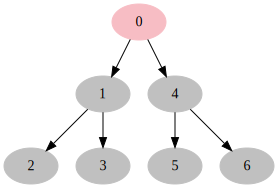

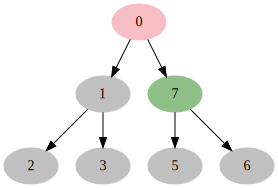

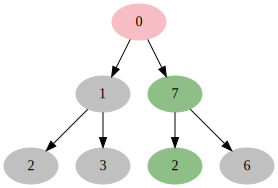

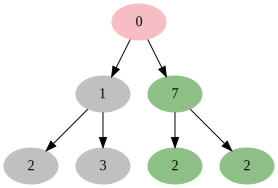

In [37]:
from IPython.display import display
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        env._state = s
        dot = env.render()
        display(dot)

from agents import run_episode
trace = run_episode(optimal_policy, env)
render(trace)

## Model

`SoftMaxPolicy` selects actions by sampling from action probabilities generated by its
`action_distribution` method. We can use that method as a likelihood model as well.
I print summary statistics to get an idea of the fit quality. "Predictive power" (a name I made up)
is very similar to _perplexity_, but it's in probability units.

In [6]:
def policy_model(policy, data):
    return data.apply(lambda row: policy.action_distribution(row.state)[row.action], axis = 1)

logp_optimal = np.log(policy_model(optimal_policy, df_optimal))
print('Probabilities of optimal policy actions under the optimal model')
print(np.exp(logp_optimal).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_optimal.mean()):.3f}', )

Probabilities of optimal policy actions under the optimal model
0.333333     23
0.500000      1
0.500000    445
0.500000      2
1.000000    428
dtype: int64

Predictive power: 0.688


# Data

In [7]:
from analysis_utils import *
VERSION = 'c0.5'
data = get_data(VERSION, '../experiment/data')
pdf = data['participants']
print(f'{len(pdf)} participants')
mdf = data['mouselab-mdp']
tdf = mdf.query('block == "test"').copy()

tdf.trial_index -= tdf.trial_index.min()
tdf.trial_index = tdf.trial_index.astype(int)
tdf.trial_id = tdf.trial_id.astype(int)

pdf['total_time'] = data['survey-text'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

tdf['clicks'] = tdf.queries.apply(extract)
tdf['n_clicks'] = tdf.clicks.apply(len)
pdf['n_clicks'] = tdf.groupby('pid').n_clicks.mean()
pdf['score'] = tdf.groupby('pid').score.sum()

9 participants


In [8]:
TRIALS = pd.read_json('../experiment/experiment/static/json/binary_tree_constant_high.json')
TRIALS = TRIALS.drop_duplicates(subset='trial_id').set_index('trial_id').stateRewards

In [24]:
assert len(tdf.pid.unique()) == tdf.pid.max() + 1
def expand(df):
    for i, row in df.iterrows():
        env = make_env(mu=3, sigma=6, ground_truth=TRIALS.loc[row.trial_id])
#         assert (hash(env) % 100000000) == row.trial_id
        for a in [*row.clicks, env.term_action]:
            yield {'pid': row.pid, 'trial_id': row.trial_id,
                   'state': env._state, 'action': a}
            env.step(a)

data = pd.DataFrame(expand(tdf))
print(f'{len(data)} observations)')
data.head()

834 observations)


,action,pid,state,trial_id
0,1,0,"(0, ((-9, 0.0547992916996), (-4, 0.15705610688...",80942098
1,4,0,"(0, 4.0, ((-9, 0.0547992916996), (-4, 0.157056...",80942098
2,7,0,"(0, 4.0, ((-9, 0.0547992916996), (-4, 0.157056...",80942098
3,4,0,"(0, ((-9, 0.0547992916996), (-4, 0.15705610688...",63853708
4,1,0,"(0, ((-9, 0.0547992916996), (-4, 0.15705610688...",63853708


In [47]:
prefs = np.stack(data.state.apply(optimal_policy.preferences))
prefs -= prefs.max(1).reshape(-1, 1)  # prevent float overflow 
idx = np.arange(len(data))
chosen = (idx, data.action.as_matrix())

In [52]:
from mouselab_policy import MouselabPolicy
rand_policy = MouselabPolicy({'term_reward': 0})
# NOTE: must run one episode before calling for action_distribution
run_episode(rand_policy, env)
p_rand = np.stack(data.state.apply(rand_policy.action_distribution))[chosen]

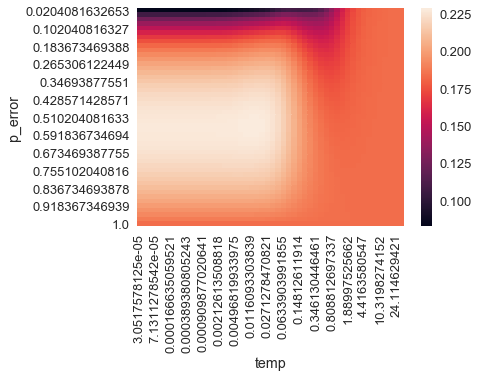

In [59]:
def logp(temp, p_error):
    eq = np.exp(prefs / temp)
    p_model = eq[chosen] / eq.sum(1)
    return np.log(p_error * p_rand + (1-p_error) * p_model)
    
def foo():
    for t in np.logspace(-15, 5, base=2):
        for pe in np.linspace(0,1)[1:]:
            yield {'temp': t, 'p_error': pe, 'perplexity': logp(t, pe).mean()}

foo = pd.DataFrame(foo())
X = np.exp(foo.set_index(['p_error', 'temp']).perplexity.unstack())
sns.heatmap(X)

In [76]:
X

temp,3.0517578125e-05,4.04966828622e-05,5.37389079868e-05,7.1311278542e-05,9.46297317494e-05,0.000125573209653,0.000166635059521,0.000221123941471,0.00029343043194,0.000389380805243,...,2.50798829026,3.32808868373,4.4163580547,5.86048639948,7.77683793143,10.3198274152,13.6943625183,18.1723547535,24.114629421,32.0
p_error,,,,,,,,,,,,,,,,,,,,,
0.020408,0.082951,0.082951,0.082951,0.082951,0.082951,0.082951,0.082951,0.082951,0.082951,0.082951,...,0.172519,0.176545,0.179184,0.180877,0.181950,0.182629,0.183059,0.183333,0.183511,0.183628
0.040816,0.107753,0.107753,0.107753,0.107753,0.107753,0.107753,0.107753,0.107753,0.107753,0.107753,...,0.173141,0.176904,0.179394,0.181001,0.182025,0.182674,0.183087,0.183351,0.183523,0.183636
0.061224,0.125111,0.125111,0.125111,0.125111,0.125111,0.125111,0.125111,0.125111,0.125111,0.125112,...,0.173733,0.177249,0.179597,0.181122,0.182098,0.182718,0.183114,0.183368,0.183534,0.183643
0.081633,0.138731,0.138731,0.138731,0.138731,0.138731,0.138731,0.138731,0.138731,0.138731,0.138731,...,0.174297,0.177582,0.179794,0.181240,0.182169,0.182762,0.183141,0.183385,0.183545,0.183650
0.102041,0.149992,0.149992,0.149992,0.149992,0.149992,0.149992,0.149992,0.149992,0.149992,0.149992,...,0.174834,0.177902,0.179985,0.181355,0.182238,0.182804,0.183168,0.183402,0.183555,0.183657
0.122449,0.159585,0.159585,0.159585,0.159585,0.159585,0.159585,0.159585,0.159585,0.159585,0.159586,...,0.175348,0.178210,0.180170,0.181466,0.182306,0.182846,0.183194,0.183419,0.183566,0.183664
0.142857,0.167914,0.167914,0.167914,0.167914,0.167914,0.167914,0.167914,0.167914,0.167914,0.167914,...,0.175837,0.178507,0.180350,0.181575,0.182372,0.182887,0.183219,0.183435,0.183577,0.183671
0.163265,0.175237,0.175237,0.175237,0.175237,0.175237,0.175237,0.175237,0.175237,0.175237,0.175238,...,0.176305,0.178792,0.180523,0.181680,0.182437,0.182927,0.183244,0.183451,0.183587,0.183678
0.183673,0.181733,0.181733,0.181733,0.181733,0.181733,0.181733,0.181733,0.181733,0.181733,0.181733,...,0.176752,0.179067,0.180691,0.181783,0.182500,0.182966,0.183269,0.183467,0.183597,0.183685


In [68]:
F = foo.set_index(['p_error', 'temp']).perplexity.unstack()

temp
0.000031     0.020408
0.000040     0.020408
0.000054     0.020408
0.000071     0.020408
0.000095     0.020408
0.000126     0.020408
0.000167     0.020408
0.000221     0.020408
0.000293     0.020408
0.000389     0.020408
0.000517     0.020408
0.000686     0.020408
0.000910     0.020408
0.001207     0.020408
0.001602     0.020408
0.002126     0.020408
0.002821     0.020408
0.003744     0.020408
0.004968     0.020408
0.006593     0.020408
0.008749     0.020408
0.011609     0.020408
0.015406     0.020408
0.020443     0.020408
0.027128     0.020408
0.035999     0.020408
0.047770     0.020408
0.063390     0.020408
0.084119     0.020408
0.111625     0.020408
0.148126     0.020408
0.196563     0.020408
0.260838     0.020408
0.346130     0.020408
0.459313     0.020408
0.609507     0.020408
0.808813     0.020408
1.073291     0.020408
1.424252     0.020408
1.889975     0.020408
2.507988     0.020408
3.328089     0.020408
4.416358     0.020408
5.860486     0.020408
7.776838     0.020408
10.31

In [28]:
logp_optimal = np.log(policy_model(optimal_policy, data))
print('Probabilities of optimal policy actions under the optimal model')
print(np.exp(logp_optimal).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_optimal.mean()):.3f}', )

Probabilities of optimal policy actions under the optimal model
0.000000    325
0.250000     17
0.333333     10
0.500000    322
1.000000    160
dtype: int64

Predictive power: 0.000


/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
